# MAGNETIZATION VECTOR FIELD RECONSTRUCTION

## Notebook Documentation

<br>
<br>
<img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
Magnetization Vector Field Reconstruction Notebook Documentation is licensed under the Creative Commons Attribution 4.0 International License (2018)
To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/.

Documentation Authors:
- Marc Rosanes
- Doga Gursoy
- Aurelio Hierro


# Magnetization vector field reconstruction principle

(1a) $$log[T_{+\delta}] + log[T_{-\delta}] = 2\int{L(t)^{-1}dt}$$  
(2a) $$log[T_{+\delta}] - log[T_{-\delta}] = 2\int{L(t)^{-1}\delta(t)[\vec{k}\bullet \vec{m(t)}]dt}$$ 


Equation 1 is used to obtain the values of the attenuation length (L), while equation (2a) will allow extracting the magnetization configuration (**m**) of the system.

It is important to note, that we are not directly reconstructing the reduced magnetization vector; we are reconstructing $2L(t)^{-1}\delta(t)\vec{m(t)}$. The contribution of the attenuation length can be accounted for by using the scalar field reconstruction using equeation (1a), and then using those values in the model to isolate $\delta(t)\vec{m(t)}$. The latter is proportional to the magnetization configuration.




*Reference for this slide: 3D reconstruction of magnetization from dichroic soft X-ray trasmission tomography (Aurelio Hierro et Al.)*

### Magnetization vector field reconstruction principle continuation

Thus it is necessary to take into account the attenuation lenght contribution, when this L is not consant throgout the object. Not taking into account L if it has high variations, would imply that we could be seeing mostly the L contribution in the reconstruction, instead of being seeing the contribution done by the magnetization **m**, in which we are interested. However, if L is quite constant throughout the object, reconstructing the full quantity $2L(t)^{-1}\delta(t)\vec{m(t)}$, will already give us a qualitative idea of the directions of the magnetization vector field **m**.


# Testing the 3D vector field reconstruction algorithm 
## From a reconstructed 3D object to its projections and back

In order to test the algorithm, the projections of a reconstructed oject can be computed, and from these projections we can come back to the reconstructed model object. If the appearance of the reconstructed model object from its computed projections is similar to the initial 3D object, this means that the vectorial reconstruction algorithm is performing correctly.

For our purposes, we will work with a simulated object with a quite constant attenuation length L throghout the object. We will find the projections of this object on the three perpendicular cartesian axis of rotation, and then we will use all this projections in order to reconstruct the object again. This will allow us to check the validity of the algorithm.

The projections of the object will give us the difference of the logarithms of the transmittance in each one of the three perpendicular axes.






### Testing the 3D vector field reconstruction algorithm


First, let's make the necessary imports

In [2]:
import dxchange
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import time

/homelocal/sicilia/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


...let us load the our object: the three components of the magnetization vector all along the object. The shapes will be read in order to verify that the object magnetization components (in this case: $2L^{-1}\delta\vec{m}$) have been correctly loaded. Afterwards we will pad the object in order to have a cubic object.


In [3]:
obx = dxchange.read_tiff('./DATA/input/object_1/M4R1_mx.tif').astype('float32')
oby = dxchange.read_tiff('./DATA/input/object_1/M4R1_my.tif').astype('float32')
obz = dxchange.read_tiff('./DATA/input/object_1/M4R1_mz.tif').astype('float32')

print(np.shape(obx))
print(np.shape(oby))
print(np.shape(obz))

npad = ((182, 182), (64, 64), (0, 0))
obx = np.pad(obx, npad, mode='constant', constant_values=0)
oby = np.pad(oby, npad, mode='constant', constant_values=0)
obz = np.pad(obz, npad, mode='constant', constant_values=0)


(44, 280, 408)
(44, 280, 408)
(44, 280, 408)


...we will downsample the three axes of each of the magnetization vector components, in order to perform the calculations more rapidly.

In [4]:
obx = tomopy.downsample(obx, level=2, axis=0)
obx = tomopy.downsample(obx, level=2, axis=1)
obx = tomopy.downsample(obx, level=2, axis=2)

oby = tomopy.downsample(oby, level=2, axis=0)
oby = tomopy.downsample(oby, level=2, axis=1)
oby = tomopy.downsample(oby, level=2, axis=2)

obz = tomopy.downsample(obz, level=2, axis=0)
obz = tomopy.downsample(obz, level=2, axis=1)
obz = tomopy.downsample(obz, level=2, axis=2)

print(np.shape(obx))
print(np.shape(oby))
print(np.shape(obz))


(102, 102, 102)
(102, 102, 102)
(102, 102, 102)


Check the subsampled inputs, to see that the given input datasets are coherent:

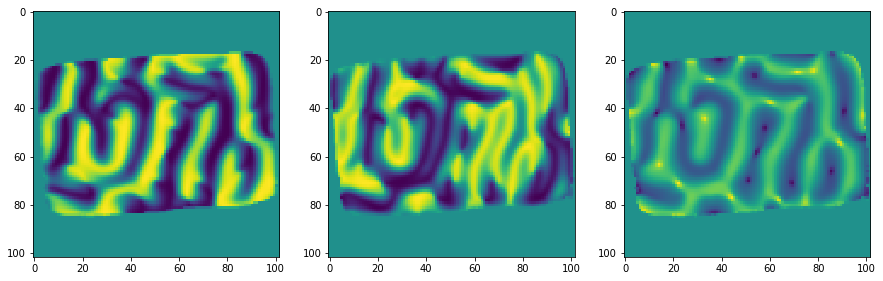

In [5]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(obx[52,:,:])
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(oby[52,:,:])
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(obz[52,:,:])


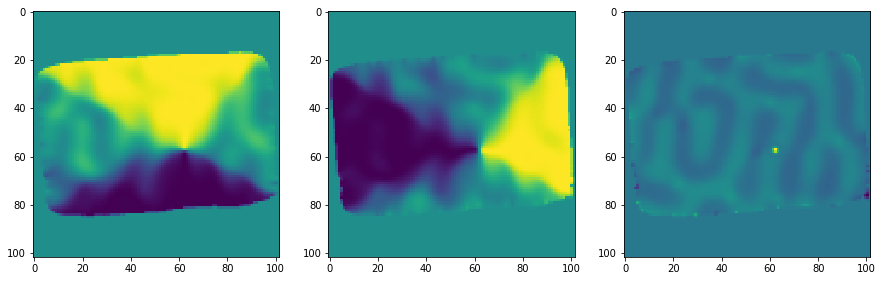

In [267]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(obx[55,:,:])
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(oby[55,:,:])
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(obz[55,:,:])


...we will define the projection angles: 31 angles, from 90 to 270 degrees:

In [163]:
ang = tomopy.angles(31, 90, 270)

...and calculate the projections of the object taking rotation axes around the three perpendicular cartesian axes:

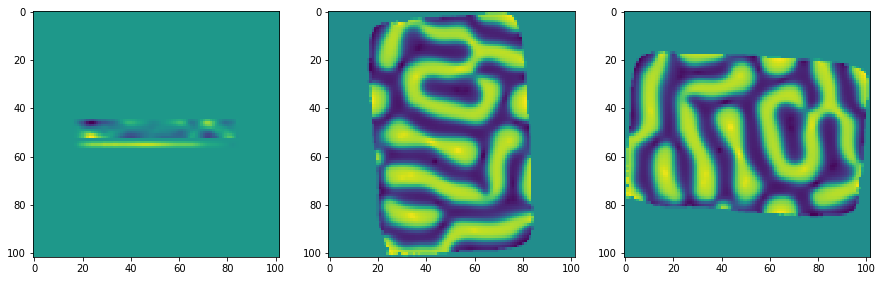

In [283]:
prj1 = tomopy.project3(obx, oby, obz, ang, axis=0, pad=False)
prj2 = tomopy.project3(obx, oby, obz, ang, axis=1, pad=False)
prj3 = tomopy.project3(obx, oby, obz, ang, axis=2, pad=False)

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(prj1[0,:,:])
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(prj2[0,:,:])
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(prj3[0,:,:])


Finally we will reconstruct the vector magnetization field components (in fact it is the quantity $2L^{-1}\delta\vec{m}$, the one which is reconstructed), taking as input the projections that we have calculated thanks to the first 3D initial object.  

In [269]:
t = time.time()
rec1, rec2, rec3 = tomopy.vector3(prj1, prj2, prj3, ang, ang, ang, axis1=0, axis2=1, axis3=2, num_iter=3)
dxchange.write_tiff(rec1)
dxchange.write_tiff(rec2)
dxchange.write_tiff(rec3)
print (time.time()-t)
print(np.shape(rec1))
print(np.shape(rec2))
print(np.shape(rec3))

6.63565993309
(102, 102, 102)
(102, 102, 102)
(102, 102, 102)


# Comparison of the test results

In this section, we compare the results of the magnetization vector field components obtained thanks to the tomopy reconstruction, against the magnetization vector field components of the object given as input:

## Comparison of the first component results: first component

Comparison of the first magnetization vector component against the input data object.

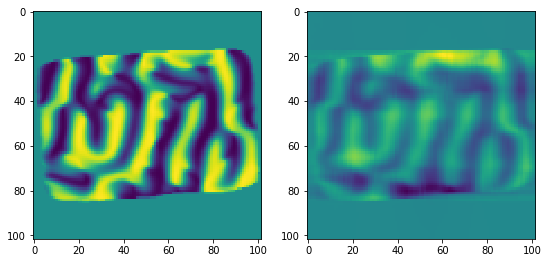

In [277]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(obx[52,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec1[52,:,:])

## Comparison of the second component results: second component

Comparison of the second magnetization vector component against the input data object:


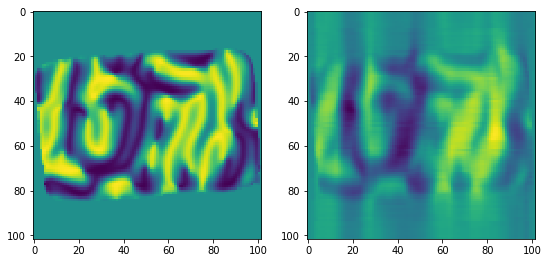

In [278]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(oby[52,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec2[52,:,:])

## Comparison of the third component results: third component

Comparison of the third magnetization vector component against the input data object:


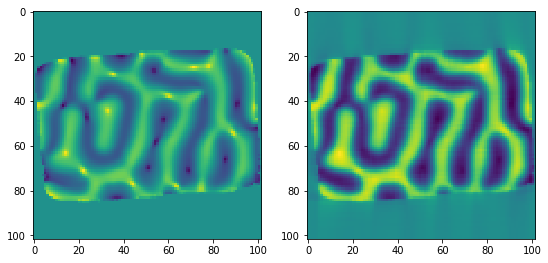

In [279]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(obz[52,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec3[52,:,:])

## Comparison of the first component results (other slice): first component

Comparison of the first magnetization vector component against the input data object.

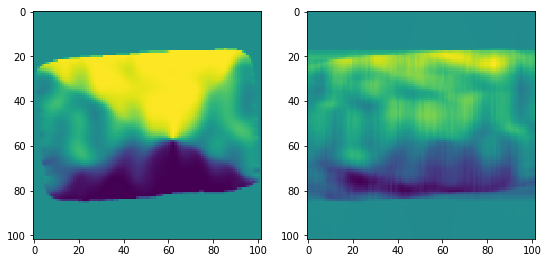

In [280]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(obx[55,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec1[55,:,:])

## Comparison of the second component results (other slice): second component

Comparison of the second magnetization vector component against the input data object:


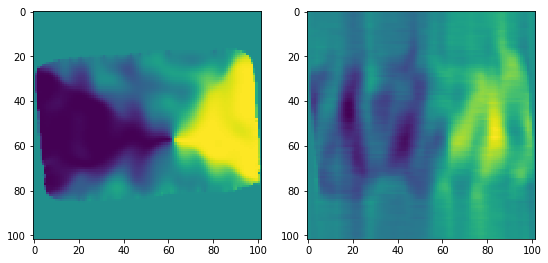

In [281]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(oby[55,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec2[55,:,:])


## Comparison of the third component results (other slice): third component

Comparison of the third magnetization vector component against the input data object:


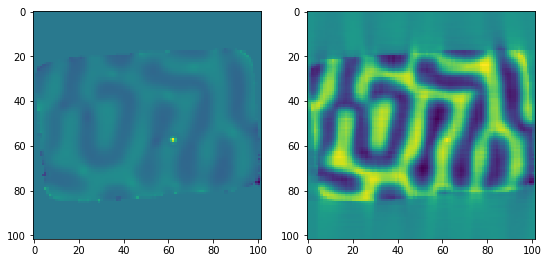

In [282]:
fig = plt.figure(figsize=(9, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(obz[55,:,:])
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(rec3[55,:,:])